Vicky Pagarani


In [26]:
#imports for the entire project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score, davies_bouldin_score

#for a cleaner look in plots
plt.style.use('seaborn-v0_8-whitegrid')
#to ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [27]:
#Data Loading and Inspection
print("--- I. Data Loading and Inspection ---")

#Loading the dataset
df_raw = pd.read_csv('C:/Users/Zer0/Documents/mkd.csv', index_col=0) 
df = df_raw.copy() # copy df


#basic info
print("\nFirst 5 rows of the dataset:")
print(df.head())

print(f"\nShape of the dataset (rows, columns): {df.shape}")

print("\nData types of columns:")
print(df.info())

print("\nSummary stats for numerical columns:")
print(df.describe())

print("\nSummary stats for object columns:")
print(df.describe(include='object'))

print("\nNumber of unique values in each column:")
for col in df.columns:
    print(f"- {col}: {df[col].nunique()} unique values")

--- I. Data Loading and Inspection ---

First 5 rows of the dataset:
   Size Size_unit      Property_type          Location Seller_name  \
0     2       BHK  Independent Floor       Uttam Nagar      seller   
1     3       BHK  Independent House        Model Town      seller   
2     2       BHK          Apartment  Sector 13 Rohini      seller   
3     3       BHK          Apartment         DLF Farms      seller   
4     3       BHK  Independent Floor       laxmi nagar      seller   

      Seller_type Rent_price  Area_sqft          Status Security_deposit  \
0  Verified Owner      8,500        500  Semi-Furnished               No   
1  Verified Owner     48,000       1020       Furnished               No   
2  Verified Owner     20,000        810     Unfurnished               No   
3  Verified Owner     11,000        750  Semi-Furnished               No   
4  Verified Owner     20,000       1300       Furnished               No   

   Bathroom Facing_direction  
0       1.0        Nor

In [28]:
print("--- Data Cleaning and Preprocessing ---")

# 1. Get the initial number of rows
initial_rows = df.shape[0]

# 2. Drop duplicate rows
df.drop_duplicates(inplace=True)

# 3. Print information about dropped duplicates
print(f"\nDropped {initial_rows - df.shape[0]} duplicate rows.")
print(f"Shape after dropping duplicates: {df.shape}")


--- Data Cleaning and Preprocessing ---

Dropped 3827 duplicate rows.
Shape after dropping duplicates: (10173, 12)


In [29]:
#Removing irrelevant columns
columns_to_drop_next = [] 

if 'Seller_name' in df.columns:
    columns_to_drop_next.append('Seller_name')
if 'Security_deposit' in df.columns:
    columns_to_drop_next.append('Security_deposit') #caused  target leakage and overfitting

if columns_to_drop_next:
    df.drop(columns=columns_to_drop_next, axis=1, inplace=True)
    print(f"Dropped columns: {columns_to_drop_next}")
else:
    print("No further columns to drop (Seller_name, Security_deposit).")


print("\nDataFrame columns after dropping:")
print(df.columns)


Dropped columns: ['Seller_name', 'Security_deposit']

DataFrame columns after dropping:
Index(['Size', 'Size_unit', 'Property_type', 'Location', 'Seller_type',
       'Rent_price', 'Area_sqft', 'Status', 'Bathroom', 'Facing_direction'],
      dtype='object')


In [30]:
# 1. Gets the initial number of rows BEFORE cleaning
initial_rows = df.shape[0]
#Logs how many rows have 'Size' exactly equal to 0
if 'Size' in df.columns:
    print(f"Number of rows where 'Size' is exactly 0: {(df['Size'] == 0).sum()}")

    # 2. Filters out rows where 'Size' is exactly 0
    df = df[df['Size'] != 0]

    rows_removed = initial_rows - df.shape[0]
    print(f"Initial number of rows: {initial_rows}")
    print(f"Removed {rows_removed} rows where 'Size' was exactly 0.")
    print(f"New shape of DataFrame: {df.shape}")
else:
    print("Column 'Size' not found.")

Number of rows where 'Size' is exactly 0: 3
Initial number of rows: 10173
Removed 3 rows where 'Size' was exactly 0.
New shape of DataFrame: (10170, 10)


In [31]:
if 'Size' in df.columns:
    print(df['Size'].min())

1


In [32]:
#Converts 'Rent_price' to numeric
if 'Rent_price' in df.columns:
    print(f"\n'Rent_price' column before conversion (first 5): \n{df['Rent_price'].head()}")
    print(f"Data type of 'Rent_price' before: {df['Rent_price'].dtype}")

    def convert_price_to_numeric(price_str):
        price_str = str(price_str).replace(',', '') # Ensure it's a string before replace
        price_str = price_str.strip().upper()
        if 'L' in price_str:
            return float(price_str.replace('L', '')) * 100000
        return float(price_str)
        
    df['Rent_price'] = df['Rent_price'].apply(convert_price_to_numeric)
        
    print(f"\n'Rent_price' column after conversion (first 5): \n{df['Rent_price'].head()}")
    print(f"Data type of 'Rent_price' after: {df['Rent_price'].dtype}")
else:
    print("Column 'Rent_price' not found.")


'Rent_price' column before conversion (first 5): 
0     8,500
1    48,000
2    20,000
3    11,000
4    20,000
Name: Rent_price, dtype: object
Data type of 'Rent_price' before: object

'Rent_price' column after conversion (first 5): 
0     8500.0
1    48000.0
2    20000.0
3    11000.0
4    20000.0
Name: Rent_price, dtype: float64
Data type of 'Rent_price' after: float64


In [33]:
from sklearn.impute import KNNImputer
print("--- KNN Imputation for 'Bathroom' and related features ---")
num_features_for_knn = ['Bathroom', 'Area_sqft', 'Size']
    
# Check if all required columns exist
if all(col in df.columns for col in num_features_for_knn):
    print(f"Selected numerical features for KNN: {num_features_for_knn}")

    df_subset_knn = df[num_features_for_knn].copy()
            
    original_index = df_subset_knn.index
    original_columns = df_subset_knn.columns

    scaler_knn = StandardScaler() 

    scaled_values_array = scaler_knn.fit_transform(df_subset_knn)
            
    df_scaled_for_knn = pd.DataFrame(scaled_values_array, columns=original_columns, index=original_index)
            
    print("\nSample of scaled data before KNN imputation:")
    print(df_scaled_for_knn.head())

    knn_imputer = KNNImputer(n_neighbors=11) 
        
    imputed_scaled_values_array = knn_imputer.fit_transform(df_scaled_for_knn) 

    print("\nSample of scaled and imputed data (NumPy array from KNNImputer):")
    print(imputed_scaled_values_array[:5]) 

    imputed_original_scale_array = scaler_knn.inverse_transform(imputed_scaled_values_array)
            
    df_imputed_original_scale = pd.DataFrame(imputed_original_scale_array, columns=original_columns, index=original_index)

    print("\nSample of imputed data (back to original scale):")
    print(df_imputed_original_scale.head())

    for col in original_columns:
        df[col] = df_imputed_original_scale[col]

    print(f"\nOriginal DataFrame 'df' updated with KNN imputed values for columns: {original_columns}.")
    print("Missing values count after KNN imputation for selected columns:")
    print(df[num_features_for_knn].isnull().sum())
else:
    print(f"One or more columns for KNN imputation not found in DataFrame: {num_features_for_knn}")

--- KNN Imputation for 'Bathroom' and related features ---
Selected numerical features for KNN: ['Bathroom', 'Area_sqft', 'Size']

Sample of scaled data before KNN imputation:
   Bathroom  Area_sqft      Size
0 -1.232181  -1.107162 -0.902441
1  0.843545  -0.882647 -0.072094
2 -0.194318  -0.973316 -0.902441
3 -1.232181  -0.999222 -0.072094
4 -0.194318  -0.761754 -0.072094

Sample of scaled and imputed data (NumPy array from KNNImputer):
[[-1.23218077 -1.1071621  -0.90244088]
 [ 0.84354517 -0.88264662 -0.07209403]
 [-0.1943178  -0.97331633 -0.90244088]
 [-1.23218077 -0.99922197 -0.07209403]
 [-0.1943178  -0.76175367 -0.07209403]]

Sample of imputed data (back to original scale):
   Bathroom  Area_sqft  Size
0       1.0      500.0   2.0
1       3.0     1020.0   3.0
2       2.0      810.0   2.0
3       1.0      750.0   3.0
4       2.0     1300.0   3.0

Original DataFrame 'df' updated with KNN imputed values for columns: Index(['Bathroom', 'Area_sqft', 'Size'], dtype='object').
Missing valu


Visualizing Facing_direction distribution BEFORE imputation:


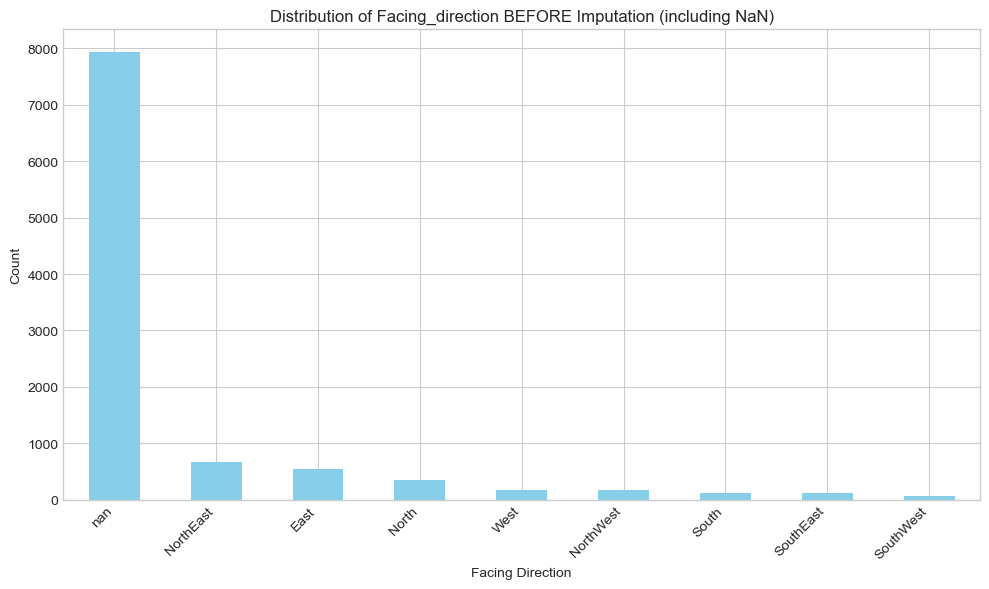

In [34]:
print("\nVisualizing Facing_direction distribution BEFORE imputation:")
plt.figure(figsize=(10, 6))
df['Facing_direction'].value_counts(dropna=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Facing_direction BEFORE Imputation (including NaN)')
plt.xlabel('Facing Direction')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
if 'Facing_direction' in df.columns:
    print(f"Handling 'Facing_direction' with {df['Facing_direction'].isnull().sum()} missing values ({df['Facing_direction'].isnull().mean()*100:.2f}%).")
        
    fill_value = "Unknown"
    df['Facing_direction'].fillna(fill_value, inplace=True)
        
    print(f"Imputed 'Facing_direction' NaNs with '{fill_value}'.")
    print(df['Facing_direction'].value_counts(dropna=False))
else:
    print("Column 'Facing_direction' not found.")

Handling 'Facing_direction' with 7938 missing values (78.05%).
Imputed 'Facing_direction' NaNs with 'Unknown'.
Facing_direction
Unknown      7938
NorthEast     670
East          543
North         345
West          177
NorthWest     170
South         128
SouthEast     124
SouthWest      75
Name: count, dtype: int64



Visualizing Facing_direction distribution AFTER imputation:


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Unknown'),
  Text(1, 0, 'NorthEast'),
  Text(2, 0, 'East'),
  Text(3, 0, 'North'),
  Text(4, 0, 'West'),
  Text(5, 0, 'NorthWest'),
  Text(6, 0, 'South'),
  Text(7, 0, 'SouthEast'),
  Text(8, 0, 'SouthWest')])

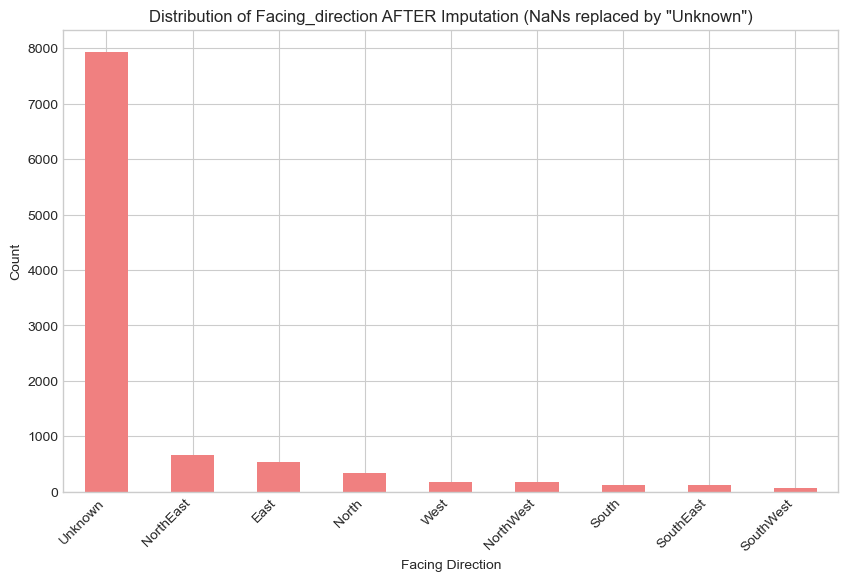

In [36]:
print("\nVisualizing Facing_direction distribution AFTER imputation:")
facing_direction_after_counts = df['Facing_direction'].value_counts(dropna=False)
plt.figure(figsize=(10, 6))
facing_direction_after_counts.plot(kind='bar', color='lightcoral')
plt.title('Distribution of Facing_direction AFTER Imputation (NaNs replaced by "Unknown")')
plt.xlabel('Facing Direction')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')


In [37]:
if 'Property_type' in df.columns:
    print(df['Property_type'].value_counts())
    wrong_value='ApartmentApartment' 
    correct_value='Apartment'
    df['Property_type']=df['Property_type'].replace(wrong_value, correct_value)
    print(f"Replaced '{wrong_value}' with '{correct_value}' in 'Property_type'.")
    print(df['Property_type'].value_counts())
else:
    print("Column 'Property_type' not found.")

Property_type
Independent Floor     6275
Apartment             1734
Villa                 1124
Independent House      688
Studio Apartment       288
Penthouse               60
ApartmentApartment       1
Name: count, dtype: int64
Replaced 'ApartmentApartment' with 'Apartment' in 'Property_type'.
Property_type
Independent Floor    6275
Apartment            1735
Villa                1124
Independent House     688
Studio Apartment      288
Penthouse              60
Name: count, dtype: int64


In [38]:
if 'Size_unit' in df.columns:
    print(df['Size_unit'].value_counts())
    wrong_value='BHKBHK' 
    correct_value='BHK'
    df['Size_unit']=df['Size_unit'].replace(wrong_value, correct_value)
    print(f"Replaced '{wrong_value}' with '{correct_value}' in 'Size_unit'.")
    print(df['Size_unit'].value_counts())
else:
    print("Column 'Size_unit' not found.")

Size_unit
BHK       9876
RK         288
BHKBHK       6
Name: count, dtype: int64
Replaced 'BHKBHK' with 'BHK' in 'Size_unit'.
Size_unit
BHK    9882
RK      288
Name: count, dtype: int64


In [39]:
if 'Bathroom' in df.columns:
    num_decimals = (df['Bathroom'] != np.floor(df['Bathroom'])).sum()
    if num_decimals > 0:
        print(f"Found approximately {num_decimals} decimal values in 'Bathroom' column.")

    df['Bathroom'] = df['Bathroom'].round(0).astype(int) 

    print(f"Unique values in 'Bathroom' after rounding : {np.sort(df['Bathroom'].unique())}")
else:
    print("Column 'Bathroom' not found.")

Found approximately 4775 decimal values in 'Bathroom' column.
Unique values in 'Bathroom' after rounding : [1 2 3 4 5 6 7 8 9]


In [40]:
print("\nPreprocessing (initial cleaning) complete.")
df_cleaned = df.copy()


Preprocessing (initial cleaning) complete.


--- III. Exploratory Data Analysis (EDA) ---

Analyzing target variable 'Rent_price':


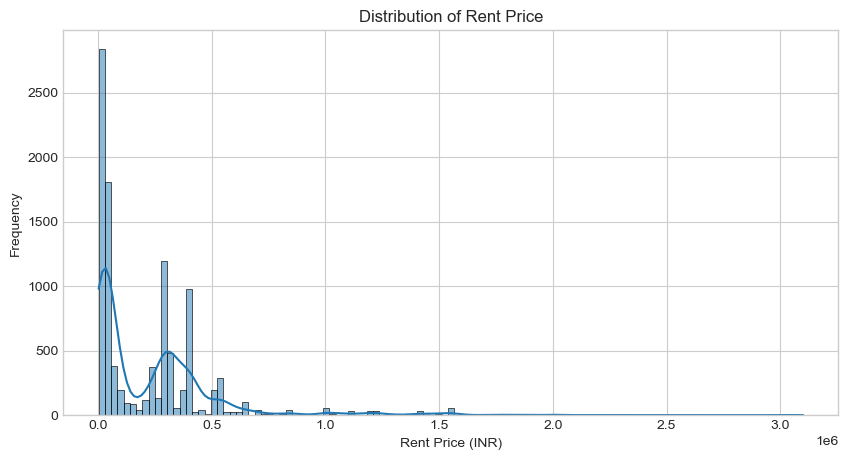

Rent Price Skewness: 2.94

Analyzing 'Area_sqft':


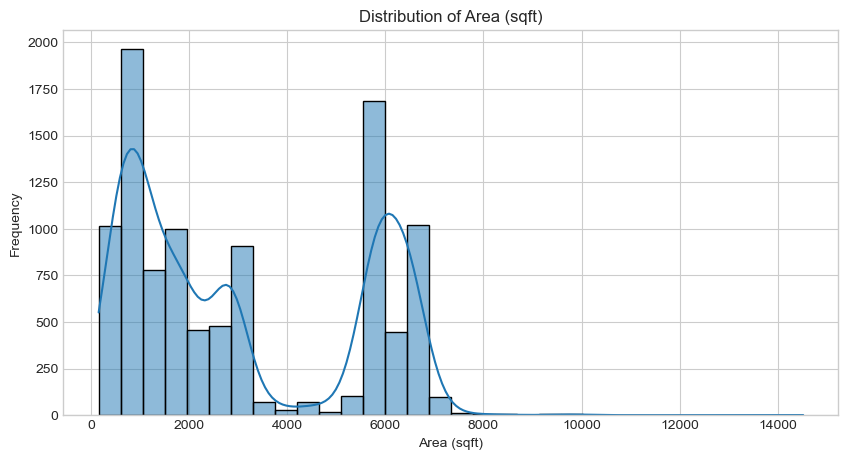


Analyzing 'Bathroom' counts:


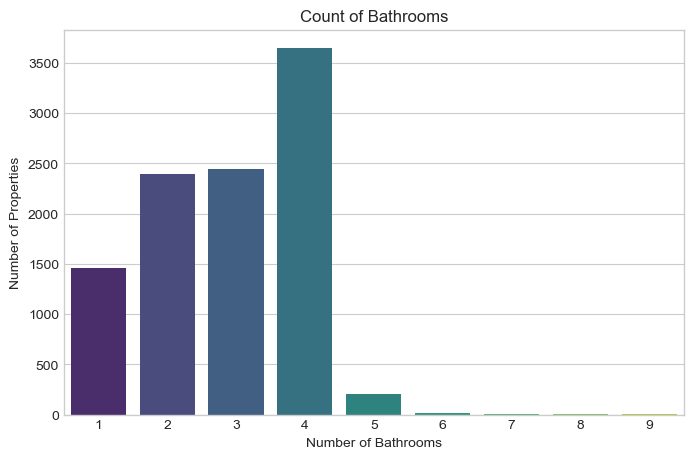


Analyzing 'Property_type':


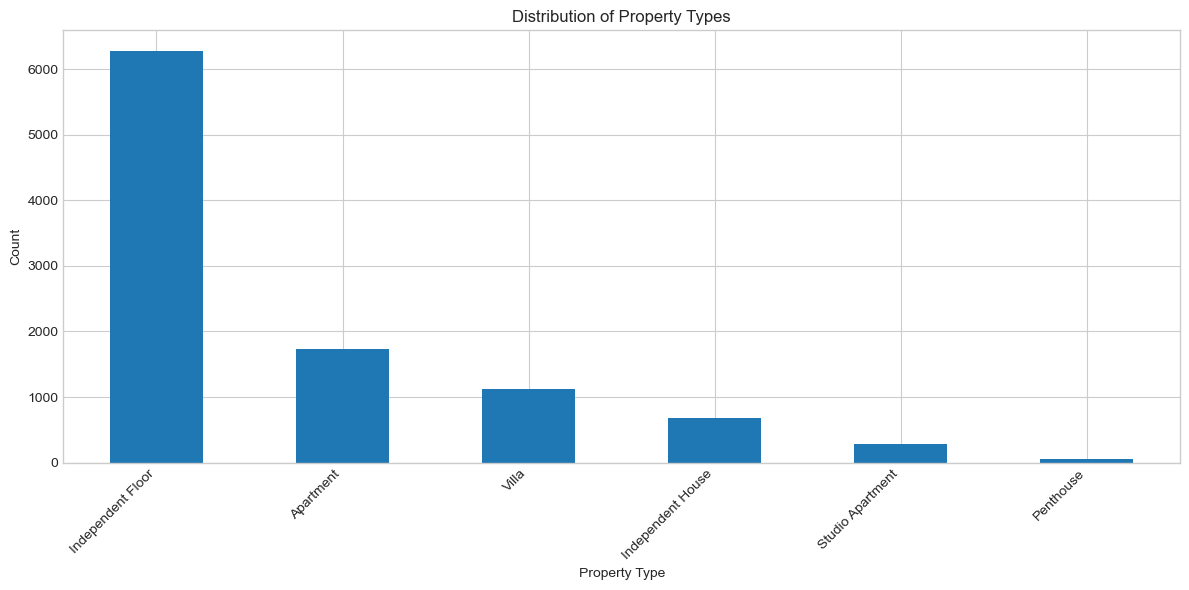


Rent Price vs. Area_sqft:


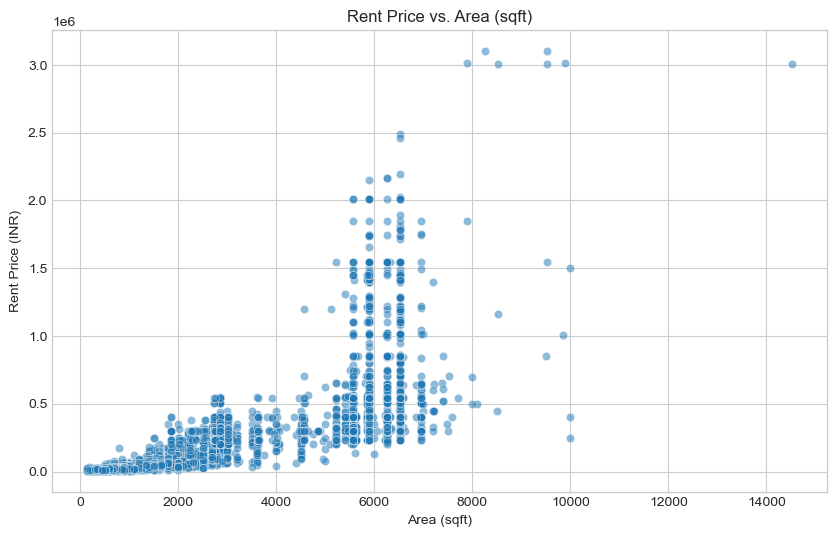


Rent Price by Property Type:


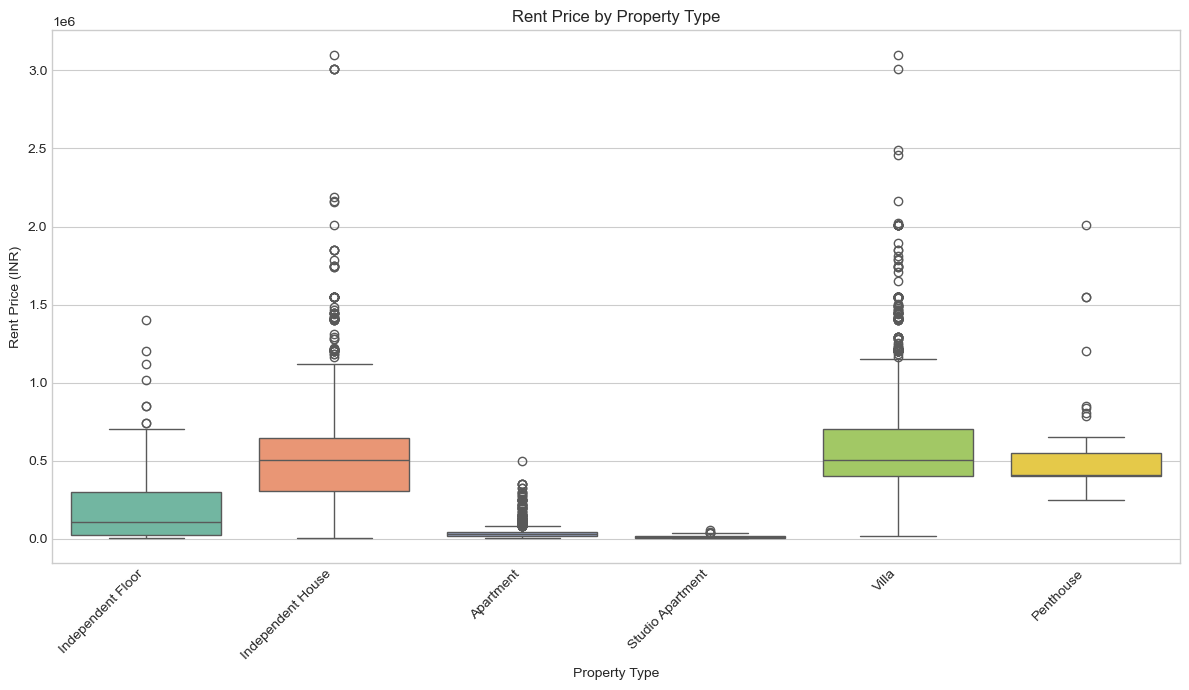


Rent Price by Number of Bathrooms:


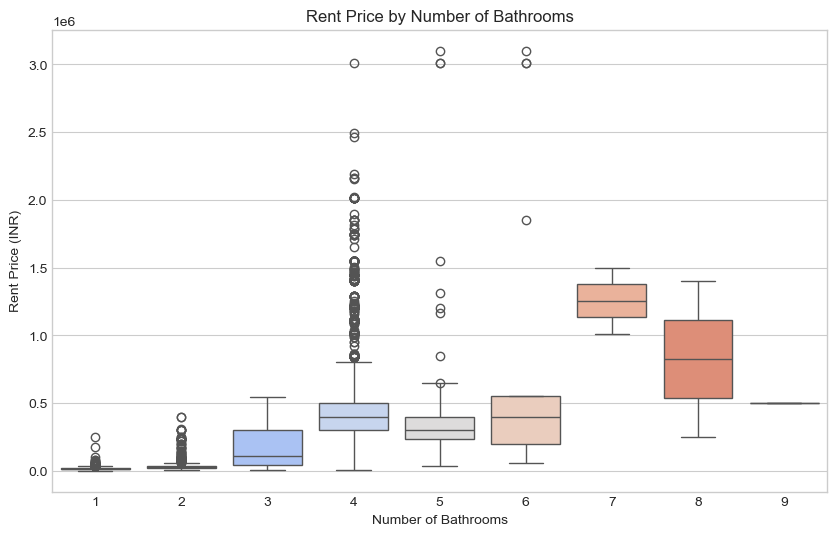

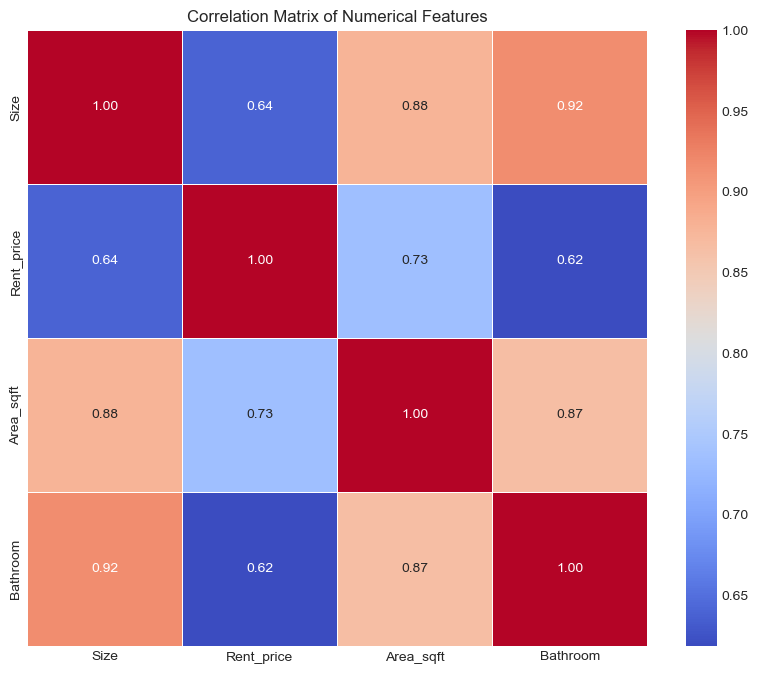


EDA complete.


In [41]:
# Step III: Exploratory Data Analysis (EDA)
print("--- III. Exploratory Data Analysis (EDA) ---")

if not df_cleaned.empty:
    # 1. Univariate Analysis 
    if 'Rent_price' in df_cleaned.columns:
        print("\nAnalyzing target variable 'Rent_price':")
        plt.figure(figsize=(10, 5))
        sns.histplot(df_cleaned['Rent_price'], kde=True)
        plt.title('Distribution of Rent Price')
        plt.xlabel('Rent Price (INR)')
        plt.ylabel('Frequency')
        plt.show()
        print(f"Rent Price Skewness: {df_cleaned['Rent_price'].skew():.2f}")

    if 'Area_sqft' in df_cleaned.columns:
        print("\nAnalyzing 'Area_sqft':")
        plt.figure(figsize=(10, 5))
        sns.histplot(df_cleaned['Area_sqft'], kde=True)
        plt.title('Distribution of Area (sqft)')
        plt.xlabel('Area (sqft)')
        plt.ylabel('Frequency')
        plt.show()

    if 'Bathroom' in df_cleaned.columns:
        print("\nAnalyzing 'Bathroom' counts:")
        plt.figure(figsize=(8, 5))
        sns.countplot(x='Bathroom', data=df_cleaned, palette='viridis')
        plt.title('Count of Bathrooms')
        plt.xlabel('Number of Bathrooms')
        plt.ylabel('Number of Properties')
        plt.show()

    if 'Property_type' in df_cleaned.columns:
        print("\nAnalyzing 'Property_type':")
        plt.figure(figsize=(12, 6))
        df_cleaned['Property_type'].value_counts().plot(kind='bar')
        plt.title('Distribution of Property Types')
        plt.xlabel('Property Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # 2. Bivariate Analysis 
    if 'Area_sqft' in df_cleaned.columns and 'Rent_price' in df_cleaned.columns:
        print("\nRent Price vs. Area_sqft:")
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Area_sqft', y='Rent_price', data=df_cleaned, alpha=0.5)
        plt.title('Rent Price vs. Area (sqft)')
        plt.xlabel('Area (sqft)')
        plt.ylabel('Rent Price (INR)')
        plt.show()

    if 'Property_type' in df_cleaned.columns and 'Rent_price' in df_cleaned.columns:
        print("\nRent Price by Property Type:")
        plt.figure(figsize=(12, 7))
        sns.boxplot(x='Property_type', y='Rent_price', data=df_cleaned, palette='Set2')
        plt.title('Rent Price by Property Type')
        plt.xlabel('Property Type')
        plt.ylabel('Rent Price (INR)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    if 'Bathroom' in df_cleaned.columns and 'Rent_price' in df_cleaned.columns:
        print("\nRent Price by Number of Bathrooms:")
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Bathroom', y='Rent_price', data=df_cleaned, palette='coolwarm')
        plt.title('Rent Price by Number of Bathrooms')
        plt.xlabel('Number of Bathrooms')
        plt.ylabel('Rent Price (INR)')
        plt.show()

    # 3. Correlation Analysis 
    numerical_df = df_cleaned.select_dtypes(include=np.number)
    if not numerical_df.empty:
        plt.figure(figsize=(10, 8))
        correlation_matrix = numerical_df.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Numerical Features')
        plt.show()
    else:
        print("No numerical features found for correlation analysis.")
else:
    print("df_cleaned is empty. Skipping EDA.")

print("\nEDA complete.")
df_eda_done = df_cleaned.copy()

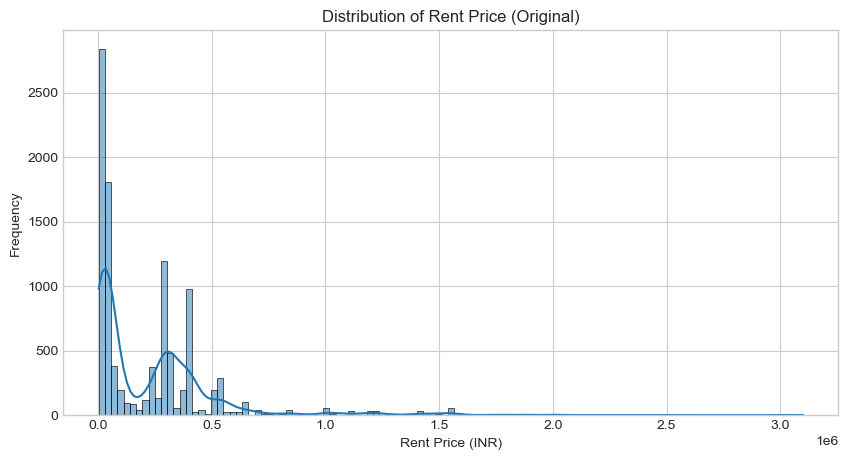

Skewness of original Rent_price: 2.94


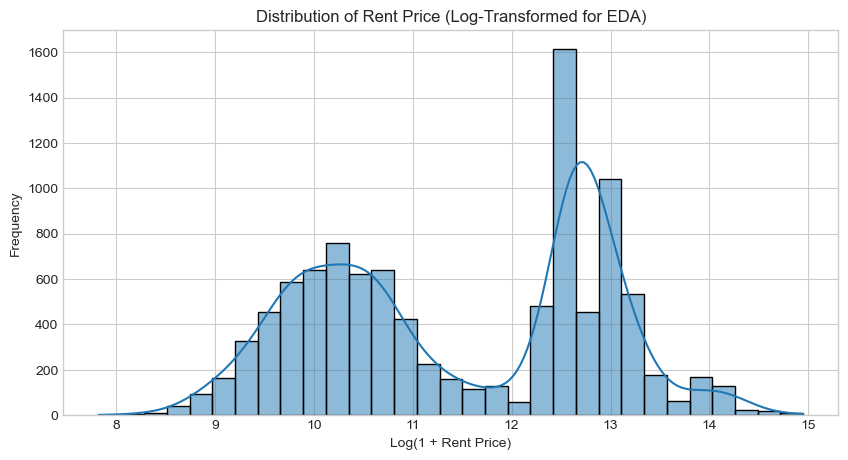

Skewness of log-transformed Rent_price: -0.05


In [42]:
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['Rent_price'], kde=True)
plt.title('Distribution of Rent Price (Original)')
plt.xlabel('Rent Price (INR)')
plt.ylabel('Frequency')
plt.show()
print(f"Skewness of original Rent_price: {df_cleaned['Rent_price'].skew():.2f}")

# Attempt log transformation for EDA
rent_price_log_transformed = np.log1p(df_cleaned['Rent_price'])
plt.figure(figsize=(10, 5))
sns.histplot(rent_price_log_transformed, kde=True)
plt.title('Distribution of Rent Price (Log-Transformed for EDA)')
plt.xlabel('Log(1 + Rent Price)')
plt.ylabel('Frequency')
plt.show()
print(f"Skewness of log-transformed Rent_price: {rent_price_log_transformed.skew():.2f}")

In [43]:
print("--- IV. Feature Engineering ---")
from category_encoders import CatBoostEncoder

--- IV. Feature Engineering ---


In [44]:
# --- Define Features (X) and Target (y) ---
if 'Rent_price' not in df_cleaned.columns:
    raise ValueError("Target column 'Rent_price' not found in df_cleaned. Cannot proceed with modeling.")

X = df_cleaned.drop('Rent_price', axis=1)
y = df_cleaned['Rent_price']

# ---  Split Data into Training and Testing sets  ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---  Manual Preprocessing ---

# Create copies to avoid modifying original X_train, X_test slices directly during transformations
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()


# ---  CatBoostEncode 'Location' ---
print("\n--- Applying CatBoostEncoder for 'Location' ---")
if 'Location' in X_train.columns:
    loc_encoder = CatBoostEncoder(cols=['Location'], sigma=0.05, random_state=42)

    # Fit on X_train and y_train (X_train has the original categorical 'Location')
    loc_encoder.fit(X_train, y_train)


    X_train_processed = loc_encoder.transform(X_train_processed)
    X_test_processed = loc_encoder.transform(X_test_processed)

    print("X_train_processed head after CatBoostEncoding 'Location':")
    print(X_train_processed.head()) # 'Location' column should now be numeric
    print("Data type of 'Location' in X_train_processed:", X_train_processed['Location'].dtype)
else:
    print("Column 'Location' not found for CatBoostEncoding. Skipping.")


# ---  One-Hot Encode other categorical features ---
print("\n--- Applying OneHotEncoder for other categoricals ---")
ohe_categorical_features = ['Property_type', 'Seller_type', 'Size_unit', 'Status', 'Facing_direction']

ohe_categorical_features = [col for col in ohe_categorical_features if col in X_train_processed.columns]

if ohe_categorical_features:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


    ohe.fit(X_train_processed[ohe_categorical_features])

    # Get feature names for OHE columns
    ohe_feature_names = ohe.get_feature_names_out(ohe_categorical_features)

    # Transform training data
    X_train_ohe_features = ohe.transform(X_train_processed[ohe_categorical_features])
    X_train_ohe_df = pd.DataFrame(X_train_ohe_features, columns=ohe_feature_names, index=X_train_processed.index)

    # Transform test data
    X_test_ohe_features = ohe.transform(X_test_processed[ohe_categorical_features])
    X_test_ohe_df = pd.DataFrame(X_test_ohe_features, columns=ohe_feature_names, index=X_test_processed.index)

    # Drop original categorical columns from X_train_processed and X_test_processed
    X_train_processed.drop(columns=ohe_categorical_features, inplace=True)
    X_test_processed.drop(columns=ohe_categorical_features, inplace=True)

    # Concatenate OHE features
    X_train_processed = pd.concat([X_train_processed, X_train_ohe_df], axis=1)
    X_test_processed = pd.concat([X_test_processed, X_test_ohe_df], axis=1)

    print(f"X_train_processed shape after OHE: {X_train_processed.shape}")
else:
    print("No categorical features found for OneHotEncoding. Skipping.")


# --- StandardScale numerical features ---
print("\n--- Applying StandardScaler for numerical features ---")
numerical_features_to_scale = ['Size', 'Bathroom', 'Area_sqft']
if 'Location' in X_train_processed.columns and X_train_processed['Location'].dtype != 'object': 
    numerical_features_to_scale.append('Location')

# Filter out features not present in X_train_processed
numerical_features_to_scale = [col for col in numerical_features_to_scale if col in X_train_processed.columns]

if numerical_features_to_scale:
    scaler = StandardScaler() # This is the main scaler for modeling features

    scaler.fit(X_train_processed[numerical_features_to_scale])

    # Transform both training and test data for these columns
    X_train_processed[numerical_features_to_scale] = scaler.transform(X_train_processed[numerical_features_to_scale])
    X_test_processed[numerical_features_to_scale] = scaler.transform(X_test_processed[numerical_features_to_scale])

    print("X_train_processed head after Scaling (sample of scaled numericals):")
    print(X_train_processed[numerical_features_to_scale].head())
else:
    print("No numerical features found for Scaling. Skipping.")


# --- Verification ---
print("\n--- Final Processed Data Samples ---")
print("X_train_processed head:")
print(X_train_processed.head())
print(f"X_train_processed shape: {X_train_processed.shape}")
print("\nX_test_processed head:")
print(X_test_processed.head())
print(f"X_test_processed shape: {X_test_processed.shape}")


--- Applying CatBoostEncoder for 'Location' ---
X_train_processed head after CatBoostEncoding 'Location':
       Size Size_unit      Property_type       Location Seller_type  \
13354   5.0       BHK  Independent House  248757.476021       Agent   
3504    2.0       BHK  Independent Floor   42045.778218       Agent   
6731    4.0       BHK              Villa  154825.319574       Agent   
3650    1.0       BHK  Independent Floor   22823.778901       Agent   
6216    3.0       BHK  Independent Floor  342854.349332       Agent   

       Area_sqft       Status  Bathroom Facing_direction  
13354     6521.0  Unfurnished         4          Unknown  
3504       850.0    Furnished         2            South  
6731      5896.0  Unfurnished         4          Unknown  
3650       825.0    Furnished         1          Unknown  
6216      2856.0  Unfurnished         3          Unknown  
Data type of 'Location' in X_train_processed: float64

--- Applying OneHotEncoder for other categoricals ---
X_t

In [45]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [46]:
import xgboost as xgb

In [47]:
print("--- Modeling ---")
models_supervised = {
    "1. Linear Regression": LinearRegression(),
    "2. Ridge Regression (L2)": Ridge(alpha=1.0, random_state=42),
    "3. Lasso Regression (L1)": Lasso(alpha=0.1, random_state=42, max_iter=5000),
    "4. Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=1, min_samples_split=2), 
    "5. Random Forest": RandomForestRegressor(n_estimators=100, max_features= 0.7, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10, min_samples_leaf=1),
    "6. Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42, min_samples_leaf=2, subsample=0.8, min_samples_split=10),
    "7. SVR (RBF Kernel)": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "8. MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42, early_stopping=True, alpha=0.001),
    "9. XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1, learning_rate=0.05, max_depth=5, colsample_bytree=0.9, reg_alpha=0, reg_lambda=1, subsample=0.9, gamma=0)
}

results_supervised = {}
trained_supervised_models = {}

print("\nTraining and evaluating models...")
if X_train_processed.empty or X_test_processed.empty:
    print("Processed training or testing data is empty. Skipping model training.")
else:
    for name, model in models_supervised.items():
        print(f"Training {name}...")
        
        model.fit(X_train_processed, y_train)
        trained_supervised_models[name] = model
            
        y_pred_train = model.predict(X_train_processed)
        y_pred_test = model.predict(X_test_processed)
            
        mae_train = mean_absolute_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_train = r2_score(y_train, y_pred_train)

        mae_test = mean_absolute_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_test = r2_score(y_test, y_pred_test)
            
        results_supervised[name] = {
            "MAE Train": mae_train, "RMSE Train": rmse_train, "R2 Train": r2_train,
            "MAE Test": mae_test, "RMSE Test": rmse_test, "R2 Test": r2_test
        }
        print(f"  {name} - Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}, Test R2: {r2_test:.4f}")
   

    results_supervised_df = pd.DataFrame(results_supervised).T.sort_values(by="RMSE Test")
    print("\n---  Model Performance Comparison (sorted by Test RMSE) ---")
    print(results_supervised_df)


--- Modeling ---

Training and evaluating models...
Training 1. Linear Regression...
  1. Linear Regression - Train RMSE: 133447.01, Test RMSE: 132717.31, Test R2: 0.7905
Training 2. Ridge Regression (L2)...
  2. Ridge Regression (L2) - Train RMSE: 133447.10, Test RMSE: 132709.44, Test R2: 0.7906
Training 3. Lasso Regression (L1)...
  3. Lasso Regression (L1) - Train RMSE: 133447.01, Test RMSE: 132717.22, Test R2: 0.7905
Training 4. Decision Tree...
  4. Decision Tree - Train RMSE: 91830.95, Test RMSE: 94093.61, Test R2: 0.8947
Training 5. Random Forest...
  5. Random Forest - Train RMSE: 80719.81, Test RMSE: 90789.38, Test R2: 0.9020
Training 6. Gradient Boosting...
  6. Gradient Boosting - Train RMSE: 71708.95, Test RMSE: 92624.22, Test R2: 0.8980
Training 7. SVR (RBF Kernel)...
  7. SVR (RBF Kernel) - Train RMSE: 321597.42, Test RMSE: 317906.50, Test R2: -0.2018
Training 8. MLP Regressor...
  8. MLP Regressor - Train RMSE: 126847.53, Test RMSE: 126210.29, Test R2: 0.8106
Training 9.


--- Model Performance Comparison (sorted by Test RMSE) ---
                              MAE Train     RMSE Train  R2 Train  \
5. Random Forest           38851.300762   80719.807470  0.923709   
9. XGBoost                 40943.895095   82191.017076  0.920903   
6. Gradient Boosting       34206.827121   71708.946350  0.939791   
4. Decision Tree           46443.458622   91830.948902  0.901261   
8. MLP Regressor           62566.445732  126847.529664  0.811602   
2. Ridge Regression (L2)   75345.178988  133447.101391  0.791489   
3. Lasso Regression (L1)   75352.209121  133447.009001  0.791489   
1. Linear Regression       75352.197659  133447.008943  0.791489   
7. SVR (RBF Kernel)       195804.675749  321597.415887 -0.210980   

                               MAE Test      RMSE Test   R2 Test  
5. Random Forest           42917.311483   90789.384840  0.901984  
9. XGBoost                 43664.928297   91134.028897  0.901239  
6. Gradient Boosting       44054.512310   92624.222270  0.

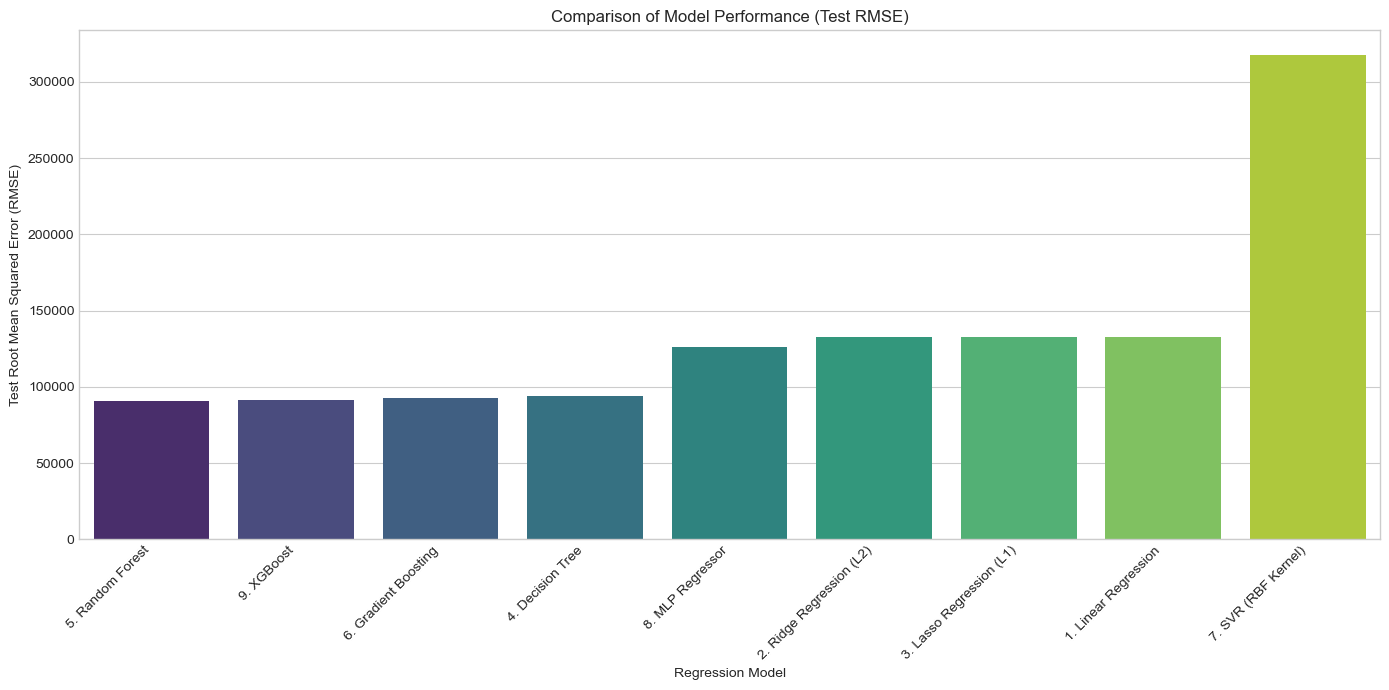

In [48]:


results_supervised_df = pd.DataFrame(results_supervised).T.sort_values(by="RMSE Test")
print("\n--- Model Performance Comparison (sorted by Test RMSE) ---")
print(results_supervised_df)

print("\n--- Visualizing Model Performance (Test RMSE) ---")

plt.figure(figsize=(14, 7)) 

plot_data = results_supervised_df.reset_index()
plot_data = plot_data.rename(columns={'index': 'Model'}) 

sns.barplot(x='Model', y='RMSE Test', data=plot_data, palette='viridis') 

plt.title('Comparison of Model Performance (Test RMSE)')
plt.xlabel('Regression Model')
plt.ylabel('Test Root Mean Squared Error (RMSE)')


plt.xticks(rotation=45, ha='right')

plt.tight_layout() 
plt.show()



In [50]:


random_forest_model_key = "5. Random Forest" # Key for Random Forest model
model_to_explain = trained_supervised_models[random_forest_model_key]

print(f"\n--- Feature Importance for: {random_forest_model_key} ---")

importances = model_to_explain.feature_importances_

feature_names = X_train_processed.columns

feature_importance_series = pd.Series(importances, index=feature_names)

feature_importance_percent = feature_importance_series * 100

sorted_feature_importance_percent = feature_importance_percent.sort_values(ascending=False)


print("\nFeature Importance:")

print(sorted_feature_importance_percent)





--- Feature Importance for: 5. Random Forest ---

Feature Importance:
Area_sqft                          41.789975
Location                           36.061652
Bathroom                            8.981859
Property_type_Independent Floor     8.098145
Size                                1.519702
Status_Unfurnished                  1.227123
Property_type_Villa                 0.875044
Property_type_Independent House     0.723678
Property_type_Apartment             0.328927
Status_Semi-Furnished               0.146620
Status_Furnished                    0.121038
Property_type_Penthouse             0.073792
Facing_direction_Unknown            0.013933
Facing_direction_East               0.009565
Seller_type_Agent                   0.007304
Facing_direction_NorthEast          0.006032
Seller_type_Owner                   0.005437
Facing_direction_North              0.003796
Facing_direction_SouthWest          0.002160
Facing_direction_South              0.001169
Facing_direction_SouthEast   


Feature Importance:
Area_sqft                          41.789975
Location                           36.061652
Bathroom                            8.981859
Property_type_Independent Floor     8.098145
Size                                1.519702
Status_Unfurnished                  1.227123
Property_type_Villa                 0.875044
Property_type_Independent House     0.723678
Property_type_Apartment             0.328927
Status_Semi-Furnished               0.146620
Status_Furnished                    0.121038
Property_type_Penthouse             0.073792
Facing_direction_Unknown            0.013933
Facing_direction_East               0.009565
Seller_type_Agent                   0.007304
Facing_direction_NorthEast          0.006032
Seller_type_Owner                   0.005437
Facing_direction_North              0.003796
Facing_direction_SouthWest          0.002160
Facing_direction_South              0.001169
Facing_direction_SouthEast          0.001017
Facing_direction_NorthWest        

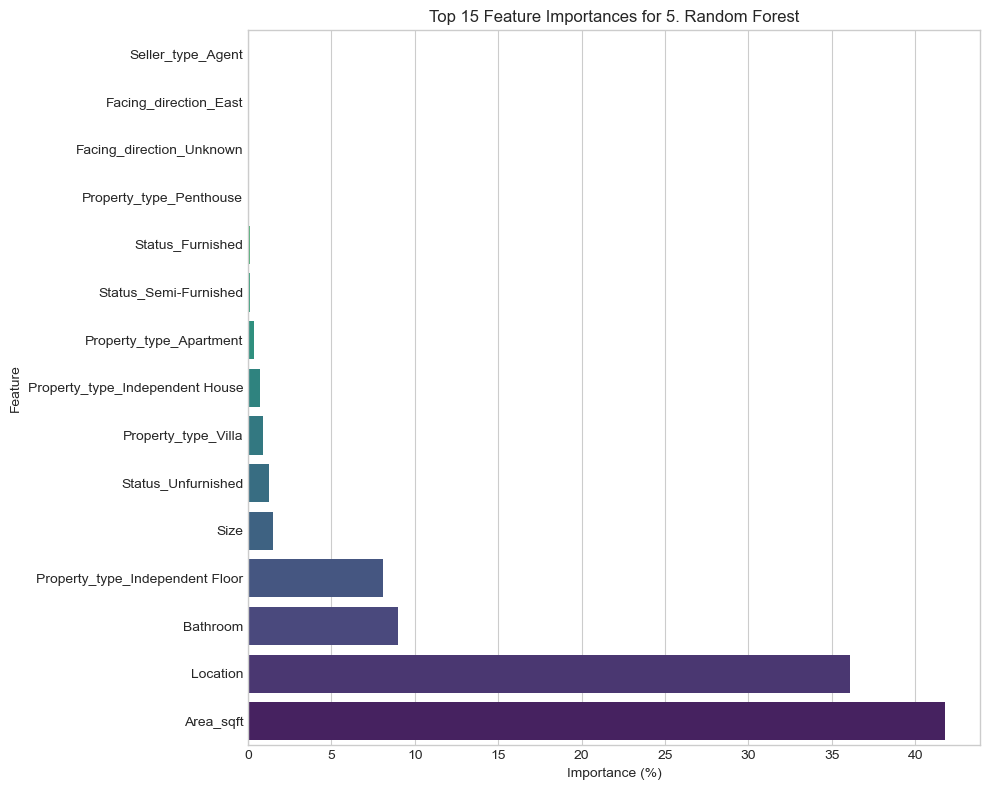

In [51]:
print("\nFeature Importance:")
print(sorted_feature_importance_percent)

print("\n--- Visualizing Top Feature Importances ---")


N = 15 


top_n_features = sorted_feature_importance_percent.head(N)


plt.figure(figsize=(10, 8)) 


plot_data_fi = top_n_features.reset_index()
plot_data_fi.columns = ['Feature', 'Importance (%)'] 

sns.barplot(x='Importance (%)', y='Feature', data=plot_data_fi, palette='viridis')

plt.title(f'Top {N} Feature Importances for {random_forest_model_key}')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')


plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [80]:
'''
print("\n--- Hyperparameter Tuning for GradientBoostingRegressor ---")

# Define the parameter grid to search
param_grid_gbr = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],   # Step size shrinkage
    'max_depth': [3, 4, 5],               # Max depth of trees
    'min_samples_split': [2, 4],          # Min samples to split
    'min_samples_leaf': [1, 2],           # Min samples at a leaf
    'subsample': [0.8, 0.9, 1.0]          # Fraction of samples for training each tree
}


# Initialize GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)


grid_search_gbr = GridSearchCV(estimator=gbr,
                               param_grid=param_grid_gbr,
                               cv=4, 
                               scoring='neg_root_mean_squared_error',
                               verbose=2, # Shows progress
                               n_jobs=-1)

print("Starting GridSearchCV for GradientBoostingRegressor... This may take some time.")
# Fit GridSearchCV on the training data
grid_search_gbr.fit(X_train_processed, y_train)

# Gets the best parameters and the best score
print("\nBest parameters found by GridSearchCV:")
print(grid_search_gbr.best_params_)

# The best_score_ will be negative RMSE. To get positive RMSE:
best_rmse_gbr_cv = -grid_search_gbr.best_score_
print(f"\nBest Cross-Validated RMSE: {best_rmse_gbr_cv:.2f}")

# Get the best estimator 
best_gbr_model = grid_search_gbr.best_estimator_
'''



'\nprint("\n--- Hyperparameter Tuning for GradientBoostingRegressor ---")\n\n# Define the parameter grid to search\nparam_grid_gbr = {\n    \'n_estimators\': [100, 200, 300],       # Number of trees\n    \'learning_rate\': [0.01, 0.05, 0.1],   # Step size shrinkage\n    \'max_depth\': [3, 4, 5],               # Max depth of trees\n    \'min_samples_split\': [2, 4],          # Min samples to split\n    \'min_samples_leaf\': [1, 2],           # Min samples at a leaf\n    \'subsample\': [0.8, 0.9, 1.0]          # Fraction of samples for training each tree\n}\n\n\n# Initialize GradientBoostingRegressor\ngbr = GradientBoostingRegressor(random_state=42)\n\n\ngrid_search_gbr = GridSearchCV(estimator=gbr,\n                               param_grid=param_grid_gbr,\n                               cv=4, \n                               scoring=\'neg_root_mean_squared_error\',\n                               verbose=2, # Shows progress\n                               n_jobs=-1)\n\nprint("Starting 

In [81]:
'''
print("-- Tuning DecisionTreeRegressor ---")
scoring_metric = 'neg_root_mean_squared_error'
dt_param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
    
}
dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42),
                              dt_param_grid, cv=4, scoring=scoring_metric, verbose=1, n_jobs=-1)
dt_grid_search.fit(X_train_processed, y_train)

print("Best Decision Tree Params:", dt_grid_search.best_params_)
print(f"Best Decision Tree CV RMSE: {-dt_grid_search.best_score_:.2f}")
best_dt_model = dt_grid_search.best_estimator_
'''

'\nprint("-- Tuning DecisionTreeRegressor ---")\nscoring_metric = \'neg_root_mean_squared_error\'\ndt_param_grid = {\n    \'max_depth\': [None, 5, 10, 15, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4, 6]\n    \n}\ndt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42),\n                              dt_param_grid, cv=4, scoring=scoring_metric, verbose=1, n_jobs=-1)\ndt_grid_search.fit(X_train_processed, y_train)\n\nprint("Best Decision Tree Params:", dt_grid_search.best_params_)\nprint(f"Best Decision Tree CV RMSE: {-dt_grid_search.best_score_:.2f}")\nbest_dt_model = dt_grid_search.best_estimator_\n'

In [82]:
'''
# ---  Hyperparameter Tuning for XGBoost Regressor ---
print("\n--- Tuning XGBoost Regressor ---")
scoring_metric = 'neg_root_mean_squared_error' # Define if not already
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],         # Fraction of samples used for training each tree
    'colsample_bytree': [0.7, 0.8, 0.9], # Fraction of features used for training each tree
    'reg_alpha': [0, 0.001, 0.01],      # L1 regularization
    'reg_lambda': [1, 0.1, 0.01]        # L2 regularization
}
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, ),
                               xgb_param_grid, cv=4, scoring=scoring_metric, verbose=1, n_jobs=-1)


xgb_grid_search.fit(X_train_processed, y_train) 

print("Best XGBoost Params:", xgb_grid_search.best_params_)
print(f"Best XGBoost CV RMSE: {-xgb_grid_search.best_score_:.2f}")
best_xgb_model = xgb_grid_search.best_estimator_

'''

'\n# ---  Hyperparameter Tuning for XGBoost Regressor ---\nprint("\n--- Tuning XGBoost Regressor ---")\nscoring_metric = \'neg_root_mean_squared_error\' # Define if not already\nxgb_param_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'max_depth\': [3, 5, 7],\n    \'subsample\': [0.7, 0.8, 0.9],         # Fraction of samples used for training each tree\n    \'colsample_bytree\': [0.7, 0.8, 0.9], # Fraction of features used for training each tree\n    \'reg_alpha\': [0, 0.001, 0.01],      # L1 regularization\n    \'reg_lambda\': [1, 0.1, 0.01]        # L2 regularization\n}\nxgb_grid_search = GridSearchCV(xgb.XGBRegressor(objective=\'reg:squarederror\', random_state=42, n_jobs=-1, ),\n                               xgb_param_grid, cv=4, scoring=scoring_metric, verbose=1, n_jobs=-1)\n\n\nxgb_grid_search.fit(X_train_processed, y_train) \n\nprint("Best XGBoost Params:", xgb_grid_search.best_params_)\nprint(f"Best XGBoost CV RMSE: {-xgb_grid

In [83]:
'''
print("\n--- Hyperparameter Tuning for RandomForestRegressor ---")
scoring_metric = 'neg_root_mean_squared_error' # Define if not already
rf_param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [10, 15, 20, None],      # Max depth of trees (None means full depth)
    'min_samples_split': [2, 5, 10],      # Min samples to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Min samples at a leaf node
    'max_features': ['sqrt', 'log2', 0.7] # Options for number of features to consider. 0.7 means 70% of features.
                                         
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1) 

grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=rf_param_grid,
                              cv=4,
                              scoring=scoring_metric,
                              verbose=2, 
                              n_jobs=-1) 

print("Starting GridSearchCV for RandomForestRegressor... This may take some time.")
# Fit GridSearchCV on the training data
grid_search_rf.fit(X_train_processed, y_train)

# Get the best parameters and the best score
print("\nBest parameters found by GridSearchCV for Random Forest:")
print(grid_search_rf.best_params_)

best_rmse_rf_cv = -grid_search_rf.best_score_
print(f"\nBest Cross-Validated RMSE for Random Forest: {best_rmse_rf_cv:.2f}")

# Get the best estimator 
best_rf_model = grid_search_rf.best_estimator_
'''


'\nprint("\n--- Hyperparameter Tuning for RandomForestRegressor ---")\nscoring_metric = \'neg_root_mean_squared_error\' # Define if not already\nrf_param_grid = {\n    \'n_estimators\': [100, 200, 300],       # Number of trees\n    \'max_depth\': [10, 15, 20, None],      # Max depth of trees (None means full depth)\n    \'min_samples_split\': [2, 5, 10],      # Min samples to split an internal node\n    \'min_samples_leaf\': [1, 2, 4],        # Min samples at a leaf node\n    \'max_features\': [\'sqrt\', \'log2\', 0.7] # Options for number of features to consider. 0.7 means 70% of features.\n                                         \n}\n\n# Initialize RandomForestRegressor\nrf = RandomForestRegressor(random_state=42, n_jobs=-1) \n\ngrid_search_rf = GridSearchCV(estimator=rf,\n                              param_grid=rf_param_grid,\n                              cv=4,\n                              scoring=scoring_metric,\n                              verbose=2, \n                     

In [84]:
#Have commented out hyper parameter tuning code just in case i need to run it all again. Have used output parameter in model building.

In [94]:

input_dict={'Property_type':'Independent Floor', 'Seller_type':'Agent', 'Size_unit':'BHK','Status':'Semi-Furnished','Facing_direction':'NorthWest','Size' :2,'Bathroom':2,'Area_sqft':650,'Location':'Saket' }
input_df_raw = pd.DataFrame([input_dict])


input_df = input_df_raw.reindex(columns=X.columns) 


input_df_processed = input_df.copy()


input_df_processed = loc_encoder.transform(input_df_processed)


current_ohe_features = [col for col in ['Property_type', 'Seller_type', 'Size_unit', 'Status', 'Facing_direction'] if col in input_df_processed.columns]

input_ohe_features_transformed = ohe.transform(input_df_processed[current_ohe_features])
input_ohe_df = pd.DataFrame(input_ohe_features_transformed, columns=ohe.get_feature_names_out(current_ohe_features), index=input_df_processed.index)

input_df_processed.drop(columns=current_ohe_features, inplace=True)
input_df_processed = pd.concat([input_df_processed, input_ohe_df], axis=1)



current_numerical_to_scale = [col for col in ['Size', 'Bathroom', 'Area_sqft', 'Location'] if col in input_df_processed.columns and input_df_processed[col].dtype != 'object']

input_df_processed[current_numerical_to_scale] = scaler.transform(input_df_processed[current_numerical_to_scale])


 
input_df_processed = input_df_processed[X_train_processed.columns]
print("\nProcessed input data for prediction:")
print(input_df_processed)
print(f"Shape of processed input: {input_df_processed.shape}")





Processed input data for prediction:
       Size  Location  Area_sqft  Bathroom  Property_type_Apartment  \
0 -0.903534 -0.368304  -1.045469 -0.789373                      0.0   

   Property_type_Independent Floor  Property_type_Independent House  \
0                              1.0                              0.0   

   Property_type_Penthouse  Property_type_Studio Apartment  \
0                      0.0                             0.0   

   Property_type_Villa  ...  Status_Unfurnished  Facing_direction_East  \
0                  0.0  ...                 0.0                    0.0   

   Facing_direction_North  Facing_direction_NorthEast  \
0                     0.0                         0.0   

   Facing_direction_NorthWest  Facing_direction_South  \
0                         1.0                     0.0   

   Facing_direction_SouthEast  Facing_direction_SouthWest  \
0                         0.0                         0.0   

   Facing_direction_Unknown  Facing_direction_Wes

In [ ]:

print("\nRaw input_df for reference:")
print(input_df_raw) 



Raw input_df for reference:
       Property_type Seller_type Size_unit          Status Facing_direction  \
0  Independent Floor       Agent       BHK  Semi-Furnished        NorthWest   

   Size  Bathroom  Area_sqft    Location  
0     2         2        650  Govindpuri  


In [92]:
# Select Model and Predict
if not input_df_processed.empty and trained_supervised_models:
    print("\nAvailable models:")
    model_names_list = list(trained_supervised_models.keys())
    for i, model_name in enumerate(model_names_list):
        print(f" {model_name}")

    while True:
        try:
            choice_str = input(f"Select a model by number (1-{len(trained_supervised_models)}) or 'q' to quit: ")
            if choice_str.lower() == 'q':
                print("Exiting model selection.")
                break
            choice = int(choice_str)
            if 1 <= choice <= len(trained_supervised_models):
                selected_model_name = model_names_list[choice-1]
                break
            else:
                print("Invalid choice. Please enter a number from the list.")
        except ValueError:
            print("Invalid input. Please enter a number or 'q'.")

    if 'selected_model_name' in locals() and selected_model_name:
        selected_model = trained_supervised_models[selected_model_name]
        print(f"\nUsing model: {selected_model_name}")

        prediction = selected_model.predict(input_df_processed)

        print(f"\nPredicted Rent Price: {prediction[0]:.2f}")
        del selected_model_name 
    else:
        print("No model selected for prediction.")
elif not trained_supervised_models:
    print("\nNo models were trained. Cannot make predictions.")
else:
    print("\nProcessed input data is empty. Cannot make predictions.")


Available models:
 1. Linear Regression
 2. Ridge Regression (L2)
 3. Lasso Regression (L1)
 4. Decision Tree
 5. Random Forest
 6. Gradient Boosting
 7. SVR (RBF Kernel)
 8. MLP Regressor
 9. XGBoost

Using model: 5. Random Forest

Predicted Rent Price: 16805.84


In [93]:
import joblib


random_forest_model_key = "5. Random Forest"
output_filename = 'trained_random_forest_model.joblib'


rf_model_to_save = trained_supervised_models[random_forest_model_key]
    
joblib.dump(rf_model_to_save, output_filename)
print(f"--- Random Forest model ('{random_forest_model_key}') saved successfully to {output_filename} ---")




--- Random Forest model ('5. Random Forest') saved successfully to trained_random_forest_model.joblib ---


In [ ]:

# import joblib
# model_filename_to_load = 'trained_random_forest_model.joblib'
# loaded_rf_model = joblib.load(model_filename_to_load)
# print(f"\n--- Random Forest model loaded successfully from {model_filename_to_load} ---")

# predictions = loaded_rf_model.predict(X_new_data_processed)



--- Model Performance Comparison (sorted by Test RMSE) ---
                              MAE Train     RMSE Train  R2 Train  \
5. Random Forest           38851.300762   80719.807470  0.923709   
9. XGBoost                 40943.895095   82191.017076  0.920903   
6. Gradient Boosting       34206.827121   71708.946350  0.939791   
4. Decision Tree           46443.458622   91830.948902  0.901261   
8. MLP Regressor           62566.445732  126847.529664  0.811602   
2. Ridge Regression (L2)   75345.178988  133447.101391  0.791489   
3. Lasso Regression (L1)   75352.209121  133447.009001  0.791489   
1. Linear Regression       75352.197659  133447.008943  0.791489   
7. SVR (RBF Kernel)       195804.675749  321597.415887 -0.210980   

                               MAE Test      RMSE Test   R2 Test  
5. Random Forest           42917.311483   90789.384840  0.901984  
9. XGBoost                 43664.928297   91134.028897  0.901239  
6. Gradient Boosting       44054.512310   92624.222270  0.

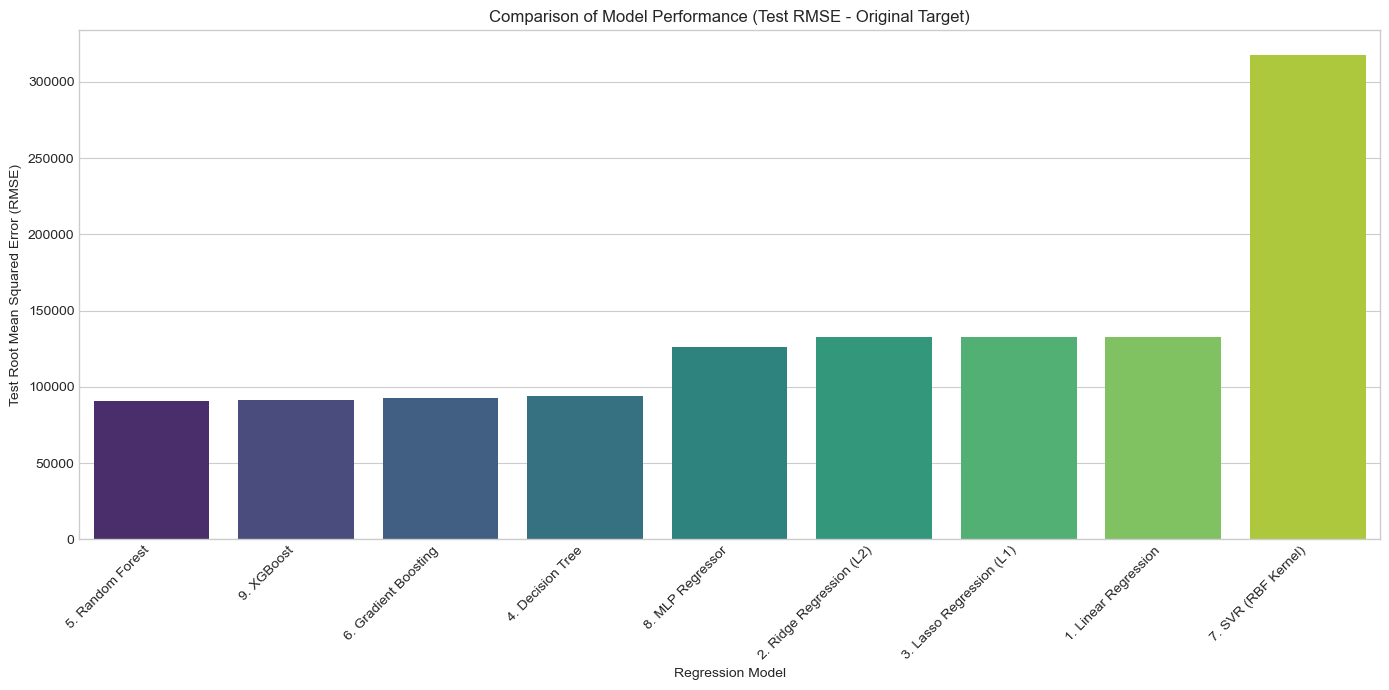


--- Modeling with Log-Transformed Rent_price ---
Log-transformed target variable 'y_log' created.
Data split for log-transformed modeling. X_train_log shape: (8136, 9), X_test_log shape: (2034, 9)
CatBoostEncoder applied to log-transformed splits.
OneHotEncoder applied to log-transformed splits.
StandardScaler applied to log-transformed splits.

X_train_log_processed shape after preprocessing: (8136, 28)
X_test_log_processed shape after preprocessing: (2034, 28)
X_test_log_processed columns reindexed to match X_train_log_processed.

Training and evaluating models with Log-Transformed Rent_price...
Training 1. Linear Regression...
 1. Linear Regression Train RMSE (Orig Scale): 269336.71, Test RMSE (Orig Scale): 212710.39, Test R2 (Log Scale): 0.8991
Training 2. Ridge Regression (L2)...
 2. Ridge Regression (L2) Train RMSE (Orig Scale): 269437.57, Test RMSE (Orig Scale): 212722.17, Test R2 (Log Scale): 0.8991
Training 3. Lasso Regression (L1)...
 3. Lasso Regression (L1) Train RMSE (Ori

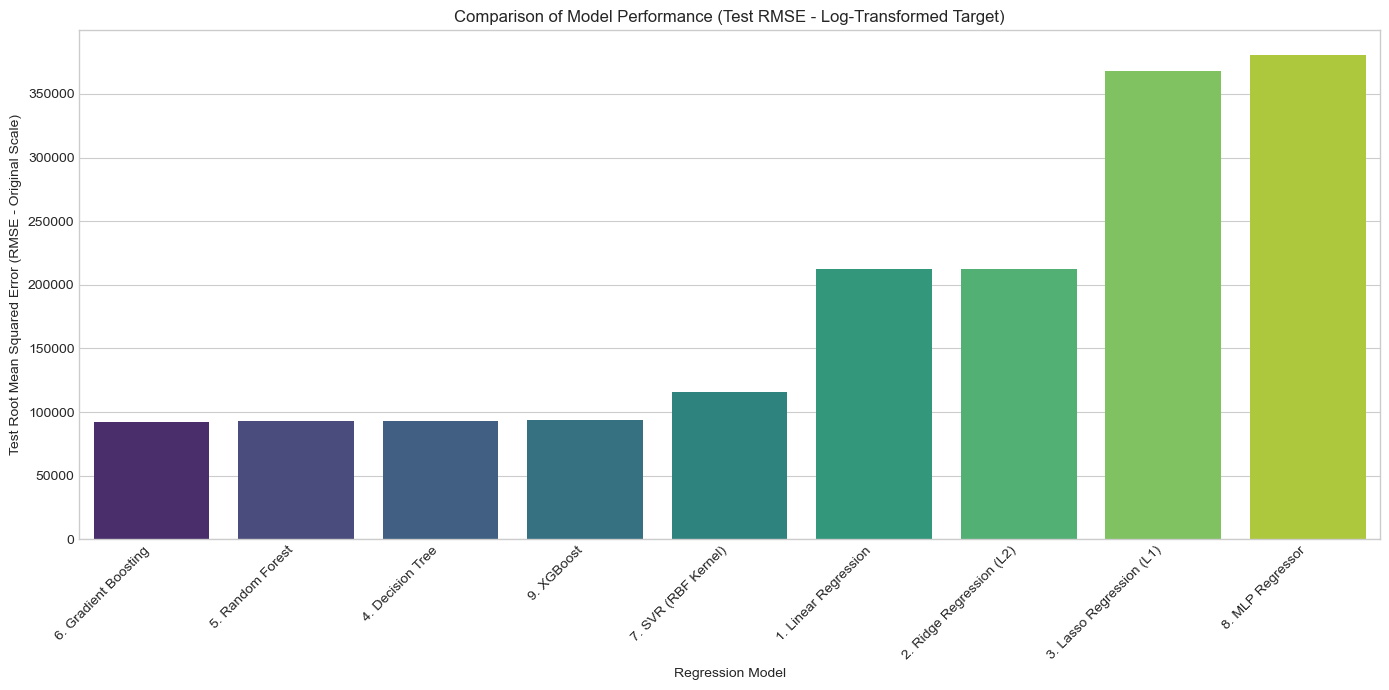

In [54]:


print("\n--- Model Performance Comparison (sorted by Test RMSE) ---")
print(results_supervised_df)


plt.figure(figsize=(14, 7))
plot_data = results_supervised_df.reset_index().rename(columns={'index': 'Model'})
sns.barplot(x='Model', y='RMSE Test', data=plot_data, palette='viridis')
plt.title('Comparison of Model Performance (Test RMSE - Original Target)')
plt.xlabel('Regression Model')
plt.ylabel('Test Root Mean Squared Error (RMSE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# --- Modeling with Log-Transformed Rent_price ---
print("\n--- Modeling with Log-Transformed Rent_price ---")


y_log = np.log1p(df_cleaned['Rent_price'])
print("Log-transformed target variable 'y_log' created.")




X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
print(f"Data split for log-transformed modeling. X_train_log shape: {X_train_log.shape}, X_test_log shape: {X_test_log.shape}")


X_train_log_processed = X_train_log.copy()
X_test_log_processed = X_test_log.copy()

X_train_log_processed = loc_encoder.transform(X_train_log_processed)
X_test_log_processed = loc_encoder.transform(X_test_log_processed)
print("CatBoostEncoder applied to log-transformed splits.")




current_ohe_features_log = [col for col in ['Property_type', 'Seller_type', 'Size_unit', 'Status', 'Facing_direction'] if col in X_train_log_processed.columns]


X_train_ohe_features_log = ohe.transform(X_train_log_processed[current_ohe_features_log])
X_test_ohe_features_log = ohe.transform(X_test_log_processed[current_ohe_features_log])

    
X_train_ohe_df_log = pd.DataFrame(X_train_ohe_features_log,
                                      columns=ohe.get_feature_names_out(current_ohe_features_log),
                                      index=X_train_log_processed.index)
X_test_ohe_df_log = pd.DataFrame(X_test_ohe_features_log,
                                     columns=ohe.get_feature_names_out(current_ohe_features_log),
                                     index=X_test_log_processed.index)

 
X_train_log_processed.drop(columns=current_ohe_features_log, inplace=True)
X_test_log_processed.drop(columns=current_ohe_features_log, inplace=True)


X_train_log_processed = pd.concat([X_train_log_processed, X_train_ohe_df_log], axis=1)
X_test_log_processed = pd.concat([X_test_log_processed, X_test_ohe_df_log], axis=1)
print("OneHotEncoder applied to log-transformed splits.")





numerical_features_to_scale_log = [col for col in ['Size', 'Bathroom', 'Area_sqft', 'Location'] if col in X_train_log_processed.columns and X_train_log_processed[col].dtype != 'object']


X_train_log_processed[numerical_features_to_scale_log] = scaler.transform(X_train_log_processed[numerical_features_to_scale_log])
X_test_log_processed[numerical_features_to_scale_log] = scaler.transform(X_test_log_processed[numerical_features_to_scale_log])
print("StandardScaler applied to log-transformed splits.")



print(f"\nX_train_log_processed shape after preprocessing: {X_train_log_processed.shape}")
print(f"X_test_log_processed shape after preprocessing: {X_test_log_processed.shape}")


X_test_log_processed = X_test_log_processed.reindex(columns=X_train_log_processed.columns, fill_value=0)
print("X_test_log_processed columns reindexed to match X_train_log_processed.")



models_log_transformed = {
    "1. Linear Regression": LinearRegression(),
    "2. Ridge Regression (L2)": Ridge(alpha=1.0, random_state=42),
    "3. Lasso Regression (L1)": Lasso(alpha=0.1, random_state=42, max_iter=5000),
    "4. Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=1, min_samples_split=2),
    "5. Random Forest": RandomForestRegressor(n_estimators=100, max_features= 0.7, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10, min_samples_leaf=1),
    "6. Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42, min_samples_leaf=2, subsample=0.8, min_samples_split=10),
    "7. SVR (RBF Kernel)": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "8. MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42, early_stopping=True, alpha=0.001),
    "9. XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1, learning_rate=0.05, max_depth=5, colsample_bytree=0.9, reg_alpha=0, reg_lambda=1, subsample=0.9, gamma=0)
}

results_log_transformed = {}
trained_log_transformed_models = {}

print("\nTraining and evaluating models with Log-Transformed Rent_price...")


for name, model in models_log_transformed.items():
    print(f"Training {name}...")

    # Train the model on the LOG-TRANSFORMED target
    model.fit(X_train_log_processed, y_train_log)
    trained_log_transformed_models[name] = model

    # Make predictions on the LOG-TRANSFORMED scale
    y_pred_train_log = model.predict(X_train_log_processed)
    y_pred_test_log = model.predict(X_test_log_processed)

    # Inverse transform predictions back to ORIGINAL scale for RMSE/MAE calculation
    y_pred_train_original_scale = np.expm1(y_pred_train_log)
    y_pred_test_original_scale = np.expm1(y_pred_test_log)

    # Calculate metrics: RMSE and MAE on ORIGINAL scale, R2 on LOG scale
    mae_train = mean_absolute_error(y_train, y_pred_train_original_scale) # Use original y_train
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_original_scale)) # Use original y_train
    r2_train = r2_score(y_train_log, y_pred_train_log) # Use log-transformed y_train

    mae_test = mean_absolute_error(y_test, y_pred_test_original_scale) # Use original y_test
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_original_scale)) # Use original y_test
    r2_test = r2_score(y_test_log, y_pred_test_log) # Use log-transformed y_test

    results_log_transformed[name] = {
            "MAE Train (Orig Scale)": mae_train,
            "RMSE Train (Orig Scale)": rmse_train,
            "R2 Train (Log Scale)": r2_train,
            "MAE Test (Orig Scale)": mae_test,
            "RMSE Test (Orig Scale)": rmse_test,
            "R2 Test (Log Scale)": r2_test
    }

    print(f" {name} Train RMSE (Orig Scale): {rmse_train:.2f}, Test RMSE (Orig Scale): {rmse_test:.2f}, Test R2 (Log Scale): {r2_test:.4f}")



results_log_transformed_df = pd.DataFrame(results_log_transformed).T.sort_values(by="RMSE Test (Orig Scale)")
print("\n--- Model Performance Comparison (Log-Transformed Target - sorted by Test RMSE on Original Scale) ---")
print(results_log_transformed_df)


print("\n--- Visualizing Model Performance (Test RMSE - Log-Transformed Target) ---")

plt.figure(figsize=(14, 7))


plot_data_log = results_log_transformed_df.reset_index()
plot_data_log = plot_data_log.rename(columns={'index': 'Model'})

sns.barplot(x='Model', y='RMSE Test (Orig Scale)', data=plot_data_log, palette='viridis')

plt.title('Comparison of Model Performance (Test RMSE - Log-Transformed Target)')
plt.xlabel('Regression Model')
plt.ylabel('Test Root Mean Squared Error (RMSE - Original Scale)')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


